In [1]:
import os
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import random
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate
from keras.optimizers import Adam
from keras import mixed_precision
from keras import backend as K
from keras.metrics import binary_crossentropy

In [2]:
keras.backend.clear_session()

In [3]:
is_gpu_available = (len(tf.config.list_physical_devices('GPU')) > 0)
print(is_gpu_available)

#mixed_precision.set_global_policy('mixed_float16')
#os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"
#os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

True


In [2]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\test_data"

In [3]:
batch_size = 6

In [4]:
def train_gen(suj_path,mask_path):
    
    datagen = ImageDataGenerator(rescale=1/255)
    seed = 777
    
    image_train_generator = datagen.flow_from_directory(suj_path,class_mode=None,color_mode="grayscale",target_size=(256,256),batch_size=batch_size,seed=seed)
    mask_train_generator = datagen.flow_from_directory(mask_path,class_mode=None,color_mode="grayscale",target_size=(256,256),batch_size=batch_size,seed=seed)
    
    train_generator = zip(image_train_generator, mask_train_generator)

    for img,mask in train_generator:
        yield(img,mask)

In [6]:
train_gen_ds = train_gen(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))

val_gen_ds = train_gen(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))


In [7]:
x,y = train_gen_ds.__next__()

Found 4741 images belonging to 1 classes.
Found 4741 images belonging to 1 classes.


In [10]:
print(x.shape)
print(y.shape)
print(x.max(),x.min())
print(y.max(),y.min())

(7, 256, 256, 1)
(7, 256, 256, 1)
1.0 0.0
1.0 0.0


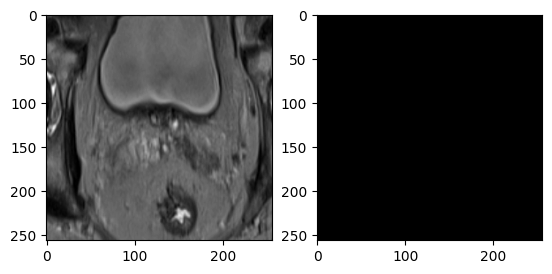

In [26]:
x,y = train_gen_ds.__next__()
for i in range(0,batch_size-1):
    image = x[i,:,:,0]
    mask = y[i,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image,cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(mask,cmap="gray")
    plt.show

In [8]:
n_train_img = len(os.listdir(os.path.join(fp1,"sujetos","img")))
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos","img")))
print(n_train_img,n_val_img)
spe = n_train_img//batch_size 
vspe = n_val_img//batch_size

4741 2391


---


In [28]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [29]:
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation, dtype="float32")(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model
my_unet = build_unet(input_shape=(256,256,1), n_classes= 1)
  #print(my_unet.summary())

In [9]:
def DiceBCE(targets, inputs, smooth=1e-2):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)

def DiceBCELoss(targets, inputs):    
    
    BCE =  binary_crossentropy(targets, inputs)
    
    return BCE + 1 - DiceBCE(targets, inputs, smooth=1e-2)

In [8]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [9]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='modelsh5/unet_model.{epoch:02d}-{val_loss:.2f}-{val_DiceBCE}.h5',save_best_only=True),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=True)
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [10]:
#optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate = 1e-3))
optimizer = Adam(learning_rate = 1e-2)

In [11]:
my_unet = keras.models.load_model("modelsh5/unet_model.14-0.10-0.9147171974182129.h5",custom_objects={"DiceBCE":DiceBCE,"DiceBCELoss":DiceBCELoss})

In [12]:
my_unet.compile(optimizer = optimizer, loss = DiceBCELoss, metrics = [DiceBCE])

In [13]:
history2 = my_unet.fit(train_gen_ds,
                    verbose=1, 
                    steps_per_epoch=spe,
                    epochs=50,
                    validation_data=val_gen_ds, 
                    validation_steps=vspe,
                    callbacks=my_callbacks)

Found 4741 images belonging to 1 classes.
Found 4741 images belonging to 1 classes.

Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50
790/790 [==============================] - ETA: 0s - loss: 0.0945 - DiceBCE: 0.9223Found 2391 images belonging to 1 classes.
Found 2391 images belonging to 1 classes.
790/790 [==============================] - 444s 545ms/step - loss: 0.0945 - DiceBCE: 0.9223 - val_loss: 0.1283 - val_DiceBCE: 0.8937 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/50
790/790 [==============================] - 423s 533ms/step - loss: 0.0908 - DiceBCE: 0.9258 - val_loss: 0.2226 - val_DiceBCE: 0.8242 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/50
790/790 [==============================] - 428s 541ms/step - loss: 0.0906 - DiceBCE: 0.9263 - val_loss: 0.1301 - val_DiceBCE: 0.8927 - lr: 0.0100

Epoch 4: LearningRateScheduler setting l

In [41]:
history2.history['val_DiceBCE']

[0.11372453719377518,
 0.5338578224182129,
 0.610298216342926,
 0.6198311448097229,
 0.7562961578369141,
 0.7193201780319214,
 0.7044329047203064,
 0.7902165055274963,
 0.7737442851066589,
 0.784243106842041,
 0.7519146800041199,
 0.7321506142616272,
 0.7258338332176208,
 0.8432258367538452,
 0.7425855994224548,
 0.8246273398399353,
 0.8125860095024109,
 0.07227186858654022,
 0.8563058376312256,
 0.5330624580383301,
 0.85707688331604,
 0.8649343848228455,
 0.8482827544212341,
 0.8937212228775024,
 0.8809022307395935,
 0.8733020424842834,
 0.871152400970459,
 0.8858485221862793,
 0.9038203954696655,
 0.8449988961219788,
 0.9020527005195618,
 0.8860621452331543,
 0.899323046207428,
 0.8899295330047607]

In [69]:
my_unet.save("1_0_926DCE_256.hdf5")

In [ ]:
my_unet.evaluate()

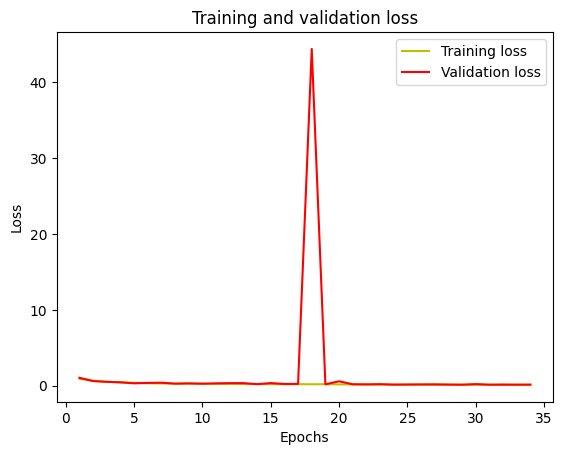

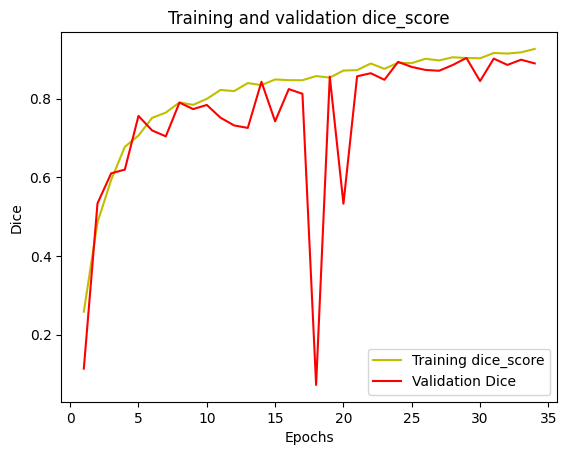

In [42]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['DiceBCE']
val_acc = history2.history['val_DiceBCE']

plt.plot(epochs, acc, 'y', label='Training dice_score')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation dice_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

1/1 [==============================] - 0s 19ms/step
Mean IoU = 0.9448496


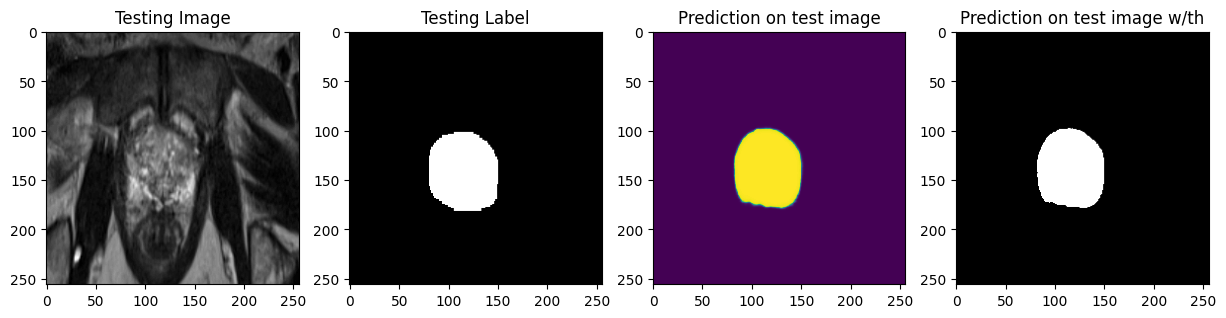

In [74]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (my_unet.predict(test_img_input))
predicted_img_th = prediction[0,:,:,0]>0.5

IOU_keras = MeanIoU(num_classes=2)  
IOU_keras.update_state(ground_truth, predicted_img_th)
print("Mean IoU =", IOU_keras.result().numpy())

plt.figure(figsize=(15, 10))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(242)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(prediction[0,:,:,0])
plt.subplot(244)
plt.title('Prediction on test image w/th')
plt.imshow(predicted_img_th, cmap='gray')
plt.show()